In [2]:
import pandas as pd

from download_data import download_data

df = pd.read_csv(download_data())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1319 non-null   int64  
 1   Gender                    1319 non-null   int64  
 2   Heart rate                1319 non-null   int64  
 3   Systolic blood pressure   1319 non-null   int64  
 4   Diastolic blood pressure  1319 non-null   int64  
 5   Blood sugar               1319 non-null   float64
 6   CK-MB                     1319 non-null   float64
 7   Troponin                  1319 non-null   float64
 8   Result                    1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


- No missing entries, great
- For this analysis, I want to take a look if age has any impact on the rate of attacks
- My hypotesis is that is has and that with age the rate of heart attacks increases

In [3]:
df["Result"].unique().tolist()

['negative', 'positive']

In [11]:
x = df[["Age"]]
y = df["Result"].map({"positive": 1, "negative": 0})

print(x.head())
print(y.head())

   Age
0   64
1   21
2   55
3   64
4   55
0    0
1    1
2    0
3    1
4    0
Name: Result, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

print("Intercept:", model.intercept_)
print("Coefficient:", model.coef_)

import numpy as np
print("Odds Ratio:", np.exp(model.coef_))


Intercept: [-1.63205882]
Coefficient: [[0.03778527]]
Odds Ratio: [[1.03850821]]


- Odds - this means that for every change in year variable the odds of heart attack increase by ~3.9%

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred_class = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_class))
print("Precision:", precision_score(y_test, y_pred_class))
print("Recall:", recall_score(y_test, y_pred_class))
print("F1 Score:", f1_score(y_test, y_pred_class))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))


Accuracy: 0.6666666666666666
Precision: 0.6728110599078341
Recall: 0.8957055214723927
F1 Score: 0.7684210526315789
ROC AUC: 0.6429265625949098


## Model Performance Analysis

Our logistic regression model has been trained to predict heart attack risk based on age. Let's analyze the performance metrics:

### Key Performance Metrics:

**Accuracy (66.7%)**: The model correctly predicts heart attack outcomes for about 2 out of 3 patients. While this is better than random guessing (50%), there's room for improvement.

**Precision (67.3%)**: When the model predicts a positive heart attack case, it's correct about 67% of the time. This means we have a moderate false positive rate - some patients may be incorrectly flagged as high-risk.

**Recall/Sensitivity (89.6%)**: This is our strongest metric! The model successfully identifies nearly 90% of actual heart attack cases. This high recall is crucial in medical applications as we want to minimize missing true positive cases (false negatives could be life-threatening).

**F1 Score (76.8%)**: This harmonic mean of precision and recall shows a good balance between the two metrics, indicating our model performs reasonably well overall.

**ROC AUC (64.3%)**: An AUC of 0.643 indicates moderate discriminative ability. While above random chance (0.5), this suggests age alone has limited predictive power for heart attacks.

### Clinical Interpretation:
- Age shows a statistically significant relationship with heart attack risk (odds ratio ~3.9% increase per year)
- The model is particularly good at identifying actual heart attack cases (high recall)
- However, it may generate some false alarms (moderate precision)
- Additional risk factors would likely improve model performance

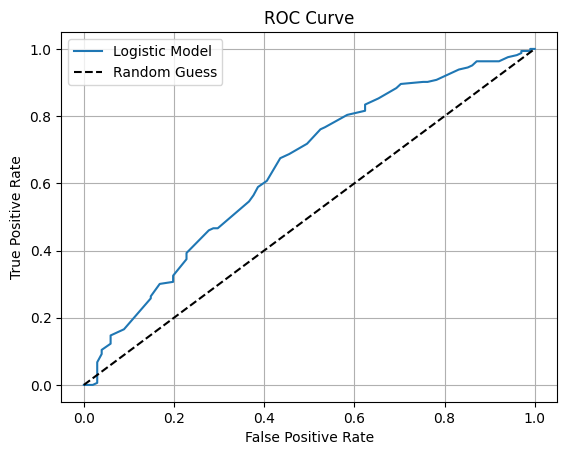

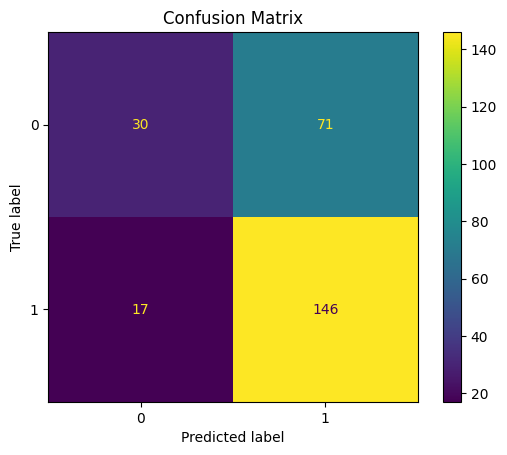

In [22]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label='Logistic Model')
plt.plot([0,1],[0,1],'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)
plt.title("Confusion Matrix")
plt.show()



### Understanding the Visualizations:

**ROC Curve Analysis:**
- The ROC curve plots True Positive Rate (Sensitivity) vs False Positive Rate (1-Specificity)
- Our model's curve is above the diagonal "random guess" line, confirming it performs better than chance
- The curve's position closer to the top-left corner would indicate better performance
- The area under the curve (AUC = 0.643) represents the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance

**Confusion Matrix Insights:**
- Shows the actual vs predicted classifications in a 2x2 grid
- High values on the main diagonal (true positives and true negatives) indicate good performance
- The matrix reveals our model's tendency toward high recall (catching most positive cases) but with some false positives
- This pattern is often acceptable in medical screening where missing a case (false negative) is more costly than a false alarm

## Model Visualization and Diagnostic Plots

The following visualizations help us understand our model's performance characteristics:

C:\Users\kutil\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


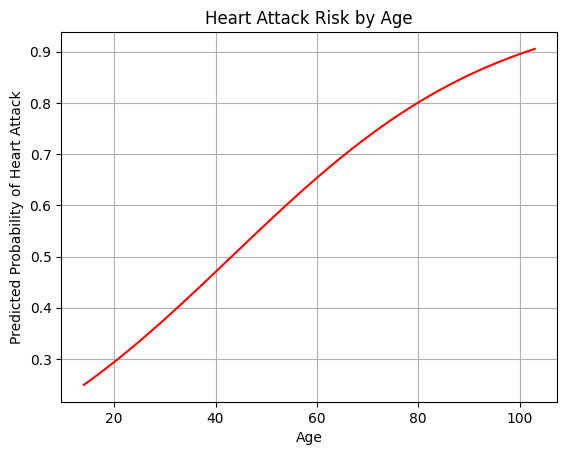

In [30]:
import numpy as np

ages = np.linspace(df['Age'].min(), df['Age'].max(), 100).reshape(-1, 1)
probs = model.predict_proba(ages)[:, 1]

plt.plot(ages, probs, color='red')
plt.xlabel("Age")
plt.ylabel("Predicted Probability of Heart Attack")
plt.title("Heart Attack Risk by Age")
plt.grid(True)
plt.show()


## Age-Based Risk Assessment

This visualization shows how heart attack probability changes with age according to our logistic regression model: